
# Mini-projet de séparation de sources audio
### I&I Apprentissage profond et traitement du signal, MVA


- *Lorenzo Brucato - auditeur externe, M2 Mathématiques et intelligence artificielle, Université Paris-Saclay & CentraleSupélec*

- *Mohamed Amir Belkacem - Telecom Paris & ENS Saclay, Mathématiques Vision Apprentissage* 

L'objectif de ce mini-projet est d'implémenter, d'entrainer et de comparer diverses architectures de réseaux de neurones profonds pour la séparation de sources audio : nous possédons un jeu de données composé de 4000 échantillons d'audio pour l'entrainement avec une partie vocale qui interfère avec un bruit de fond sonore (donnée d'entrée) et les composantes vocale et de bruit réelles (sources cibles). L'objectif est d'extraire séparemment à partir des deux sources chacune de ces deux sources, en obtenant un signal sonore composé uniquement de la partie vocale et un signal sonore ne contenant que le bruit de fond.

Pour chacun des audios, le SNR (signal to noise ratio) indique le niveau de puissance de l'une des sources par rapport à l'autre (de -4dB lorsque le bruit est supérieur de 4dB à la composante vocale, 0dB pour l'équilibre des deux sources et jusqu'à 4dB lorsque la composante vocale prend l'avantage sur le bruit de fond)

Pour chacune des architectures analysées, nous verrons l'approche mise en place (passage par une représentation temps/fréquence du signal ou non, utilisation de la forme d'onde, architecture de convolution/déconvolution ou réseaux de neurones récurrents...) et écouterons la qualité de l'audio extrait.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import mir_eval
from torchsummary import summary
import torchaudio
import IPython

from Datasets.Audiodata import *
from Models.UNet import *
from Models.UNet2 import * 
from Models.WaveUNet import *
from Models.TasNet import *

___
### 1. Chargement des données et visualisation

*Chargement du dataset :*

In [2]:
dataset = Audiodataset(set='train_small')
print(len(dataset))

50


*Forme d'onde :*

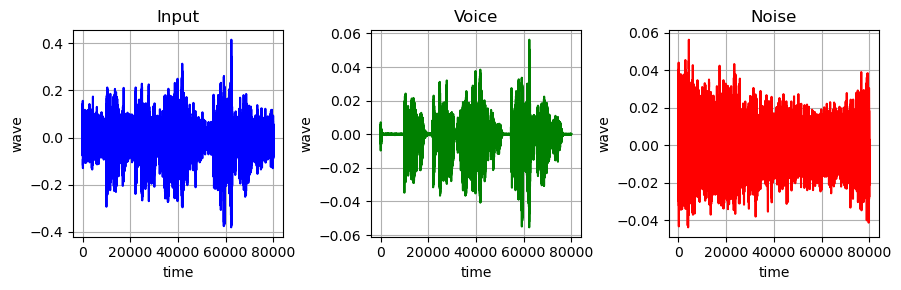

In [3]:
dataset.take_wave()
dataset.plot(0)

*Représentation temps/fréquence :*

c:\Users\User\anaconda3\Lib\site-packages\torch\functional.py:704: UserWarning: A window was not provided. A rectangular window will be applied,which is known to cause spectral leakage. Other windows such as torch.hann_window or torch.hamming_window can are recommended to reduce spectral leakage.To suppress this warning and use a rectangular window, explicitly set `window=torch.ones(n_fft, device=<device>)`. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\SpectralOps.cpp:842.)
  return _VF.stft(  # type: ignore[attr-defined]


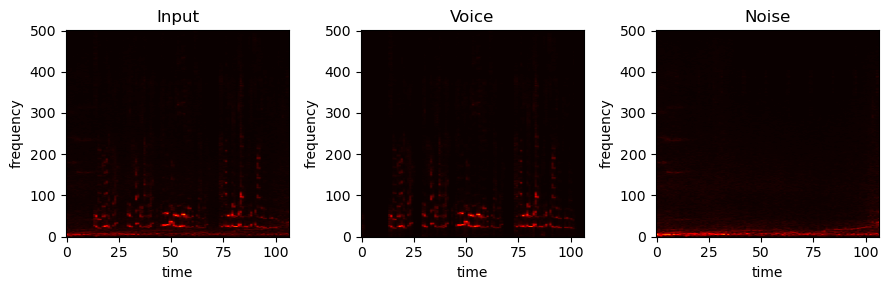

In [4]:
dataset.take_spectrogram()
dataset.plot(0)
plt.savefig('Figs/sp.png')

*Reconstruction du son depuis la représentation temps/fréquence (istft) :*

In [5]:
idx = 0
sr = 8000

dataset = Audiodataset('test', padding=True)
dataset.return_only_voice()
dataset.take_spectrogram()
X, VoiceSP = dataset[idx]

reconstruct = dataset.reconstruct(VoiceSP, idx, reference='voice')
IPython.display.Audio(reconstruct.squeeze().numpy(), rate=sr)

c:\Users\User\Documents\Projets\dlts-project\Datasets\Audiodata.py:206: UserWarning: A window was not provided. A rectangular window will be applied.Please provide the same window used by stft to make the inversion lossless.To suppress this warning and use a rectangular window, explicitly set `window=torch.ones(n_fft, device=<device>)`. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\SpectralOps.cpp:1028.)
  return torch.istft(reconstruct, n_fft=self.__n_fft, hop_length=self.__hop_length, length=original.size(1))


*Distribution de la répartition des sons selon leur snr de base :*

In [6]:
snr_sum = []
for snr in range(-4, 5):
    snr_sum.append(len(Audiodataset('train', snr_filter=snr)))

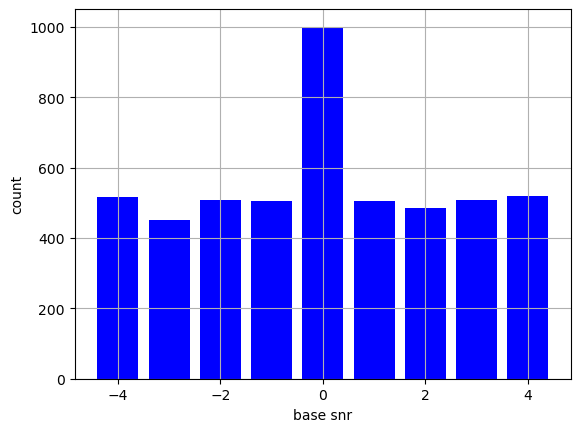

In [7]:
plt.bar(range(-4, 5), snr_sum, color='blue')
plt.xlabel('base snr')
plt.ylabel('count')
plt.grid()

___
### 2. UNet à un seul canal de sortie

Dans cette partie on implémente et visualise les résultats obtenus par UNet sur la représentation temps/fréquence du modèle tel que décris par Jansson et al. (2017) https://archives.ismir.net/ismir2017/paper/000171.pdf. L'architecture comprend trois phases : 
- Le passage de la donnée initiale dans le domaine temps fréquence par transformation de fourier
- L'entrainement d'un réseau de neurones profond par architecture UNet apprenant à générer un masque appliqué à la représentation pour extraire les deux sources du signal
- La reconstruction du signal ensuite à partir de la phase de la donnée initiale par transformée de fourrier inverse (istft)

Pour s'adapter aux dimensions de l'article et faciliter les dimensions obtenues par convolutions successives, on réalise également un padding sur les images temps/fréquence.

*Détail des dimensions sur les couches du réseau :*

In [8]:
model = UNet().to(device)
summary(model, input_size = (1,512,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 256, 64]             416
       BatchNorm2d-2          [-1, 16, 256, 64]              32
         LeakyReLU-3          [-1, 16, 256, 64]               0
       EncodeBlock-4          [-1, 16, 256, 64]               0
            Conv2d-5          [-1, 32, 128, 32]          12,832
       BatchNorm2d-6          [-1, 32, 128, 32]              64
         LeakyReLU-7          [-1, 32, 128, 32]               0
       EncodeBlock-8          [-1, 32, 128, 32]               0
            Conv2d-9           [-1, 64, 64, 16]          51,264
      BatchNorm2d-10           [-1, 64, 64, 16]             128
        LeakyReLU-11           [-1, 64, 64, 16]               0
      EncodeBlock-12           [-1, 64, 64, 16]               0
           Conv2d-13           [-1, 128, 32, 8]         204,928
      BatchNorm2d-14           [-1, 128

*Nombre de paramètres : ~9.82M*

In [9]:
print(np.sum([p.numel() for p in model.parameters()]))

9823317


#### -- Modèle pour la composante vocale --

*Données pour l'entrainement du modèle :*

In [10]:
voice_train_dataset = Audiodataset('train', padding = True,  getitem='voice')
voice_train_dataset.take_spectrogram()

voice_test_dataset = Audiodataset('test', padding = True,getitem='voice')
voice_test_dataset.take_spectrogram()

*Entrainement :*

In [ ]:
# ==== Entrainement du modèle ====
# voice_model, voice_losses = UNet.trainModel(voice_train_dataset, data_type='Voice', n_epochs=40, batch_size=16, learning_rate=0.001, valid_dataset=voice_test_dataset, schedule = True)

c:\Users\User\Documents\Projets\dlts-project\Models\UNet.py:160: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(PATH, data_type,

['model_10.pth']


100%|██████████| 313/313 [00:17<00:00, 17.39it/s]


Epoch 11/50 - Train Loss: 0.0017419
Valid Loss: 0.0016866


100%|██████████| 313/313 [00:26<00:00, 11.99it/s]


Epoch 12/50 - Train Loss: 0.0017271
Valid Loss: 0.0016757


100%|██████████| 313/313 [00:26<00:00, 11.64it/s]


Epoch 13/50 - Train Loss: 0.0017171
Valid Loss: 0.0016825


100%|██████████| 313/313 [00:28<00:00, 11.05it/s]


Epoch 14/50 - Train Loss: 0.0017061
Valid Loss: 0.0016733


100%|██████████| 313/313 [00:28<00:00, 10.86it/s]


Epoch 15/50 - Train Loss: 0.0016982
Valid Loss: 0.0016825


100%|██████████| 313/313 [00:28<00:00, 11.08it/s]


Epoch 16/50 - Train Loss: 0.0016895
Valid Loss: 0.0016680


100%|██████████| 313/313 [00:27<00:00, 11.49it/s]


Epoch 17/50 - Train Loss: 0.0016806
Valid Loss: 0.0016654


100%|██████████| 313/313 [00:26<00:00, 11.92it/s]


Epoch 18/50 - Train Loss: 0.0016760
Valid Loss: 0.0016714


100%|██████████| 313/313 [00:25<00:00, 12.07it/s]


Epoch 19/50 - Train Loss: 0.0016689
Valid Loss: 0.0016592


100%|██████████| 313/313 [00:26<00:00, 11.97it/s]


Epoch 20/50 - Train Loss: 0.0016633
Valid Loss: 0.0016575


100%|██████████| 313/313 [00:25<00:00, 12.14it/s]


Epoch 21/50 - Train Loss: 0.0016564
Valid Loss: 0.0016636


100%|██████████| 313/313 [00:30<00:00, 10.42it/s]


Epoch 22/50 - Train Loss: 0.0016507
Valid Loss: 0.0016574


100%|██████████| 313/313 [00:28<00:00, 11.07it/s]


Epoch 23/50 - Train Loss: 0.0016479
Valid Loss: 0.0016554


100%|██████████| 313/313 [00:25<00:00, 12.15it/s]


Epoch 24/50 - Train Loss: 0.0016414
Valid Loss: 0.0016578


100%|██████████| 313/313 [00:30<00:00, 10.24it/s]


Epoch 25/50 - Train Loss: 0.0016376
Valid Loss: 0.0016513


100%|██████████| 313/313 [00:29<00:00, 10.48it/s]


Epoch 26/50 - Train Loss: 0.0016333
Valid Loss: 0.0016605


100%|██████████| 313/313 [00:28<00:00, 10.81it/s]


Epoch 27/50 - Train Loss: 0.0016300
Valid Loss: 0.0016536


100%|██████████| 313/313 [00:31<00:00,  9.89it/s]


Epoch 28/50 - Train Loss: 0.0016258
Valid Loss: 0.0016481


100%|██████████| 313/313 [00:29<00:00, 10.67it/s]


Epoch 29/50 - Train Loss: 0.0016226
Valid Loss: 0.0016541


100%|██████████| 313/313 [00:30<00:00, 10.40it/s]


Epoch 30/50 - Train Loss: 0.0016195
Valid Loss: 0.0016516


100%|██████████| 313/313 [00:30<00:00, 10.20it/s]


Epoch 31/50 - Train Loss: 0.0016160
Valid Loss: 0.0016545


100%|██████████| 313/313 [00:31<00:00,  9.86it/s]


Epoch 32/50 - Train Loss: 0.0016134
Valid Loss: 0.0016572


100%|██████████| 313/313 [00:31<00:00,  9.96it/s]


Epoch 33/50 - Train Loss: 0.0016082
Valid Loss: 0.0016514


100%|██████████| 313/313 [00:31<00:00,  9.97it/s]


Epoch 34/50 - Train Loss: 0.0016057
Valid Loss: 0.0016465


100%|██████████| 313/313 [00:31<00:00,  9.82it/s]


Epoch 35/50 - Train Loss: 0.0016043
Valid Loss: 0.0016490


100%|██████████| 313/313 [00:30<00:00, 10.16it/s]


Epoch 36/50 - Train Loss: 0.0016015
Valid Loss: 0.0016496


100%|██████████| 313/313 [00:30<00:00, 10.30it/s]


Epoch 37/50 - Train Loss: 0.0015993
Valid Loss: 0.0016533


100%|██████████| 313/313 [00:28<00:00, 11.03it/s]


Epoch 38/50 - Train Loss: 0.0015963
Valid Loss: 0.0016455


100%|██████████| 313/313 [00:31<00:00,  9.95it/s]


Epoch 39/50 - Train Loss: 0.0015944
Valid Loss: 0.0016513


100%|██████████| 313/313 [00:30<00:00, 10.22it/s]


Epoch 40/50 - Train Loss: 0.0015925
Valid Loss: 0.0016465


100%|██████████| 313/313 [00:26<00:00, 12.00it/s]


Epoch 41/50 - Train Loss: 0.0015890
Valid Loss: 0.0016492


100%|██████████| 313/313 [00:26<00:00, 11.83it/s]


Epoch 42/50 - Train Loss: 0.0015888
Valid Loss: 0.0016498


100%|██████████| 313/313 [00:29<00:00, 10.48it/s]


Epoch 43/50 - Train Loss: 0.0015861
Valid Loss: 0.0016481


100%|██████████| 313/313 [00:29<00:00, 10.78it/s]


Epoch 44/50 - Train Loss: 0.0015853
Valid Loss: 0.0016480
Scheduler stepped. New Learning Rate: 0.0001000


100%|██████████| 313/313 [00:29<00:00, 10.60it/s]


Epoch 45/50 - Train Loss: 0.0015720
Valid Loss: 0.0016376


100%|██████████| 313/313 [00:30<00:00, 10.27it/s]


Epoch 46/50 - Train Loss: 0.0015681
Valid Loss: 0.0016371


100%|██████████| 313/313 [00:30<00:00, 10.34it/s]


Epoch 47/50 - Train Loss: 0.0015662
Valid Loss: 0.0016381


100%|██████████| 313/313 [00:28<00:00, 10.96it/s]


Epoch 48/50 - Train Loss: 0.0015642
Valid Loss: 0.0016376


100%|██████████| 313/313 [00:29<00:00, 10.64it/s]


Epoch 49/50 - Train Loss: 0.0015625
Valid Loss: 0.0016388


100%|██████████| 313/313 [00:31<00:00,  9.90it/s]


Epoch 50/50 - Train Loss: 0.0015621
Valid Loss: 0.0016381


*Evolution de la loss* :

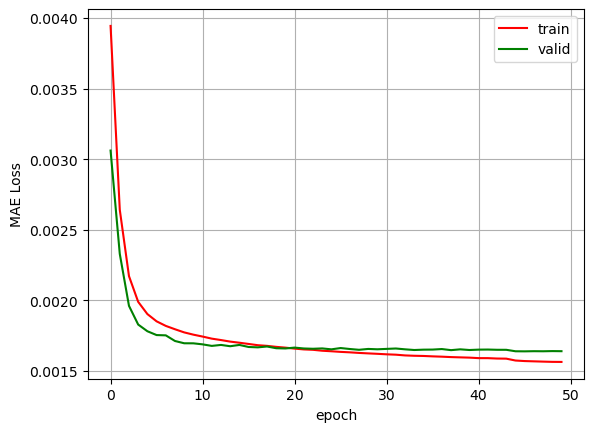

In [13]:
voice_scores_UNet = pd.read_csv('Scores/UNet/Voice/UNetMAE.csv')
voice_train_error = voice_scores_UNet['train']
voice_valid_error = voice_scores_UNet['valid']

plt.plot(voice_train_error, color='red', label='train')
plt.plot(voice_valid_error, color='green', label='valid')
plt.grid()
plt.legend()
plt.xlabel('epoch')
plt.ylabel('MAE Loss')
plt.savefig('Figs/UNet_voice_loss.png')

*Analyse de la qualité sonore :*

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
voice_model = UNet().to(device)
voice_model.load_state_dict(torch.load('Paths/UNet/Voice/model_50.pth', map_location=device))

# échantillon de test
idx = 2

C:\Users\User\AppData\Local\Temp\ipykernel_11196\847444034.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  voice_model.load_state_dict(torch.load('Paths/UNet/Voice/model

*Masque généré pour une donnée test :*

In [15]:
X, Y = voice_test_dataset[idx]
X_ = X.unsqueeze(0).unsqueeze(0).to(device)
output = voice_model(X_)

(512, 128) (512, 128)


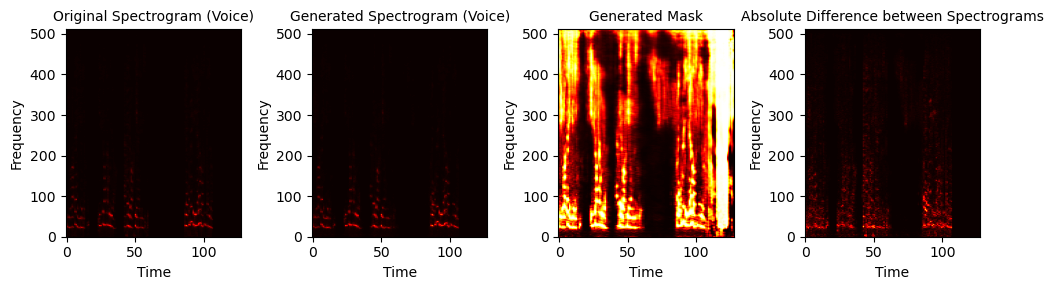

In [16]:
pred = output * X_

Vtrue = Y.detach().cpu().numpy()  # Move to CPU before converting to NumPy
Vpred = (pred).squeeze().detach().cpu().numpy()  # Move to CPU before converting to NumPy
mask = output.squeeze().detach().cpu().numpy()
mix = X.squeeze().detach().cpu().numpy()

print(Vpred.shape, Vtrue.shape)

fig, axs = plt.subplots(1, 4, figsize=(10, 3))

axs[0].imshow(Vtrue, aspect='auto', origin='lower', cmap='hot')
axs[0].set_title('Original Spectrogram (Voice)', fontsize=10)  # Reduce title size
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Frequency')

axs[1].imshow(Vpred, aspect='auto', origin='lower', cmap='hot')
axs[1].set_title('Generated Spectrogram (Voice)', fontsize=10)  # Reduce title size
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Frequency')

axs[2].imshow(mask, aspect='auto', origin='lower', cmap='hot')
axs[2].set_title('Generated Mask', fontsize=10)  # Reduce title size
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Frequency')

axs[3].imshow(np.abs(Vpred - Vtrue), aspect='auto', origin='lower', cmap='hot')
axs[3].set_title('Absolute Difference between Spectrograms', fontsize=10)  # Reduce title size
axs[3].set_xlabel('Time')
axs[3].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('Figs/UNet_voice_sp.png')
plt.show()

*Comparaison voix originale, voix générée :*

In [20]:
reconstructed_true = voice_test_dataset.reconstruct(Y, id0=idx, reference='input')
IPython.display.Audio(reconstructed_true.detach().numpy(), rate=8000)

In [21]:
reconstructed_output = voice_test_dataset.reconstruct(pred.cpu(), id0=idx, reference='input')
IPython.display.Audio(reconstructed_output.detach().numpy(), rate=8000)

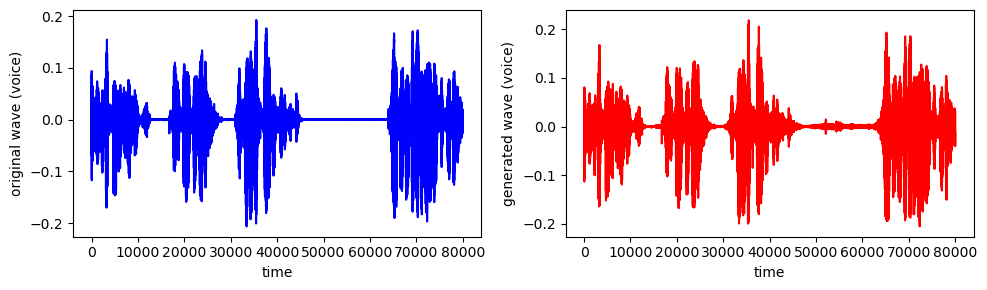

In [22]:
S_true = reconstructed_true.squeeze().detach().numpy()
S_pred = reconstructed_output.squeeze().detach().numpy()
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].plot(S_true, color='blue')
axs[0].set_xlabel('time')
axs[0].set_ylabel('original wave (voice)')

axs[1].plot(S_pred, color='red')
axs[1].set_xlabel('time')
axs[1].set_ylabel('generated wave (voice)')
plt.savefig('Figs/UNet_voice_wave.png')

plt.tight_layout()

#### -- Modèle pour la composante de fond --

*Données pour l'entraînement du modèle :*

In [23]:
noise_train_dataset = Audiodataset('train',padding = True,  getitem='noise')
noise_train_dataset.take_spectrogram()

noise_test_dataset = Audiodataset('test', padding = True,getitem='noise')
noise_test_dataset.take_spectrogram()

*Entraînement :*

In [24]:
# === Entrainement ===
# noise_model, noise_losses = UNet.trainModel(noise_train_dataset, data_type='Noise', n_epochs=50, batch_size=16, learning_rate=0.001, valid_dataset=noise_test_dataset, schedule = True)

[]


100%|██████████| 313/313 [00:28<00:00, 10.89it/s]


Epoch 1/50 - Train Loss: 0.0078258
Valid Loss: 0.0072678


100%|██████████| 313/313 [00:18<00:00, 16.77it/s]


Epoch 2/50 - Train Loss: 0.0068088
Valid Loss: 0.0064793


100%|██████████| 313/313 [00:20<00:00, 15.19it/s]


Epoch 3/50 - Train Loss: 0.0063847
Valid Loss: 0.0062566


100%|██████████| 313/313 [00:22<00:00, 13.97it/s]


Epoch 4/50 - Train Loss: 0.0062086
Valid Loss: 0.0061050


100%|██████████| 313/313 [00:23<00:00, 13.09it/s]


Epoch 5/50 - Train Loss: 0.0061105
Valid Loss: 0.0060094


100%|██████████| 313/313 [00:25<00:00, 12.31it/s]


Epoch 6/50 - Train Loss: 0.0060518
Valid Loss: 0.0059806


100%|██████████| 313/313 [00:24<00:00, 12.52it/s]


Epoch 7/50 - Train Loss: 0.0060116
Valid Loss: 0.0059426


100%|██████████| 313/313 [00:23<00:00, 13.34it/s]


Epoch 8/50 - Train Loss: 0.0059847
Valid Loss: 0.0059000


100%|██████████| 313/313 [00:21<00:00, 14.36it/s]


Epoch 9/50 - Train Loss: 0.0059643
Valid Loss: 0.0058762


100%|██████████| 313/313 [00:25<00:00, 12.39it/s]


Epoch 10/50 - Train Loss: 0.0059445
Valid Loss: 0.0058751


100%|██████████| 313/313 [00:24<00:00, 12.70it/s]


Epoch 11/50 - Train Loss: 0.0059247
Valid Loss: 0.0058762


100%|██████████| 313/313 [00:24<00:00, 12.56it/s]


Epoch 12/50 - Train Loss: 0.0059207
Valid Loss: 0.0059244


100%|██████████| 313/313 [00:25<00:00, 12.50it/s]


Epoch 13/50 - Train Loss: 0.0059128
Valid Loss: 0.0058541


100%|██████████| 313/313 [00:23<00:00, 13.20it/s]


Epoch 14/50 - Train Loss: 0.0059022
Valid Loss: 0.0058574


100%|██████████| 313/313 [00:24<00:00, 12.65it/s]


Epoch 15/50 - Train Loss: 0.0058976
Valid Loss: 0.0058459


100%|██████████| 313/313 [00:24<00:00, 12.65it/s]


Epoch 16/50 - Train Loss: 0.0058862
Valid Loss: 0.0058636


100%|██████████| 313/313 [00:24<00:00, 12.62it/s]


Epoch 17/50 - Train Loss: 0.0058813
Valid Loss: 0.0058682


100%|██████████| 313/313 [00:25<00:00, 12.41it/s]


Epoch 18/50 - Train Loss: 0.0058833
Valid Loss: 0.0058459


100%|██████████| 313/313 [00:24<00:00, 12.69it/s]


Epoch 19/50 - Train Loss: 0.0058673
Valid Loss: 0.0058382


100%|██████████| 313/313 [00:24<00:00, 12.87it/s]


Epoch 20/50 - Train Loss: 0.0058652
Valid Loss: 0.0058414


100%|██████████| 313/313 [00:23<00:00, 13.18it/s]


Epoch 21/50 - Train Loss: 0.0058659
Valid Loss: 0.0058445


100%|██████████| 313/313 [00:24<00:00, 12.57it/s]


Epoch 22/50 - Train Loss: 0.0058569
Valid Loss: 0.0058384


100%|██████████| 313/313 [00:24<00:00, 12.74it/s]


Epoch 23/50 - Train Loss: 0.0058549
Valid Loss: 0.0058451


100%|██████████| 313/313 [00:24<00:00, 12.60it/s]


Epoch 24/50 - Train Loss: 0.0058486
Valid Loss: 0.0058380


100%|██████████| 313/313 [00:24<00:00, 12.91it/s]


Epoch 25/50 - Train Loss: 0.0058514
Valid Loss: 0.0058279


100%|██████████| 313/313 [00:25<00:00, 12.43it/s]


Epoch 26/50 - Train Loss: 0.0058488
Valid Loss: 0.0058467


100%|██████████| 313/313 [00:24<00:00, 12.52it/s]


Epoch 27/50 - Train Loss: 0.0058420
Valid Loss: 0.0058502


100%|██████████| 313/313 [00:24<00:00, 12.67it/s]


Epoch 28/50 - Train Loss: 0.0058399
Valid Loss: 0.0058620


100%|██████████| 313/313 [00:24<00:00, 12.77it/s]


Epoch 29/50 - Train Loss: 0.0058376
Valid Loss: 0.0058354


100%|██████████| 313/313 [00:24<00:00, 12.92it/s]


Epoch 30/50 - Train Loss: 0.0058392
Valid Loss: 0.0058334


100%|██████████| 313/313 [00:24<00:00, 13.03it/s]


Epoch 31/50 - Train Loss: 0.0058308
Valid Loss: 0.0058320
Scheduler stepped. New Learning Rate: 0.0001000


100%|██████████| 313/313 [00:24<00:00, 12.66it/s]


Epoch 32/50 - Train Loss: 0.0058213
Valid Loss: 0.0058226


100%|██████████| 313/313 [00:25<00:00, 12.32it/s]


Epoch 33/50 - Train Loss: 0.0058174
Valid Loss: 0.0058225


100%|██████████| 313/313 [00:25<00:00, 12.52it/s]


Epoch 34/50 - Train Loss: 0.0058220
Valid Loss: 0.0058224


100%|██████████| 313/313 [00:24<00:00, 12.68it/s]


Epoch 35/50 - Train Loss: 0.0058128
Valid Loss: 0.0058219


100%|██████████| 313/313 [00:24<00:00, 12.58it/s]


Epoch 36/50 - Train Loss: 0.0058156
Valid Loss: 0.0058225


100%|██████████| 313/313 [00:25<00:00, 12.48it/s]


Epoch 37/50 - Train Loss: 0.0058168
Valid Loss: 0.0058223


100%|██████████| 313/313 [00:24<00:00, 12.96it/s]


Epoch 38/50 - Train Loss: 0.0058132
Valid Loss: 0.0058222


100%|██████████| 313/313 [00:23<00:00, 13.60it/s]


Epoch 39/50 - Train Loss: 0.0058079
Valid Loss: 0.0058226


100%|██████████| 313/313 [00:22<00:00, 13.73it/s]


Epoch 40/50 - Train Loss: 0.0058122
Valid Loss: 0.0058227


100%|██████████| 313/313 [00:22<00:00, 13.67it/s]


Epoch 41/50 - Train Loss: 0.0058114
Valid Loss: 0.0058228
Scheduler stepped. New Learning Rate: 0.0000100


100%|██████████| 313/313 [00:23<00:00, 13.14it/s]


Epoch 42/50 - Train Loss: 0.0058107
Valid Loss: 0.0058222


100%|██████████| 313/313 [00:25<00:00, 12.49it/s]


Epoch 43/50 - Train Loss: 0.0058091
Valid Loss: 0.0058221


100%|██████████| 313/313 [00:24<00:00, 12.93it/s]


Epoch 44/50 - Train Loss: 0.0058090
Valid Loss: 0.0058228


100%|██████████| 313/313 [00:24<00:00, 12.84it/s]


Epoch 45/50 - Train Loss: 0.0058084
Valid Loss: 0.0058220


100%|██████████| 313/313 [00:24<00:00, 12.90it/s]


Epoch 46/50 - Train Loss: 0.0058098
Valid Loss: 0.0058223


100%|██████████| 313/313 [00:24<00:00, 12.70it/s]


Epoch 47/50 - Train Loss: 0.0058097
Valid Loss: 0.0058222
Scheduler stepped. New Learning Rate: 0.0000010


100%|██████████| 313/313 [00:24<00:00, 12.86it/s]


Epoch 48/50 - Train Loss: 0.0058091
Valid Loss: 0.0058222


100%|██████████| 313/313 [00:24<00:00, 12.97it/s]


Epoch 49/50 - Train Loss: 0.0058117
Valid Loss: 0.0058227


100%|██████████| 313/313 [00:24<00:00, 12.94it/s]


Epoch 50/50 - Train Loss: 0.0058097
Valid Loss: 0.0058220


*Evolution de la loss :*

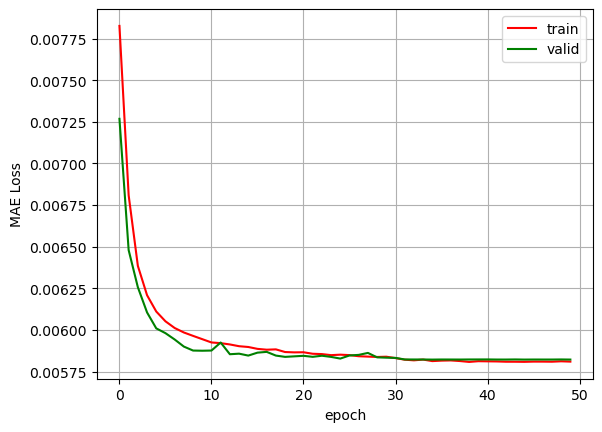

In [25]:
noise_scores_UNet = pd.read_csv('Scores/UNet/Noise/UNetMAE.csv')
noise_train_error = noise_scores_UNet['train']
noise_valid_error = noise_scores_UNet['valid']

plt.plot(noise_train_error, color='red', label='train')
plt.plot(noise_valid_error, color='green', label='valid')
plt.grid()
plt.legend()
plt.xlabel('epoch')
plt.ylabel('MAE Loss')
plt.savefig('Figs/UNet_noise_loss.png')

*Analyse de la qualité sonore sur une donnée test :*

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
noise_model = UNet().to(device)
noise_model.load_state_dict(torch.load('Paths/UNet/Noise/model_50.pth', map_location=device))

# échantillon test
idx = 100

C:\Users\User\AppData\Local\Temp\ipykernel_11196\820206576.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  noise_model.load_state_dict(torch.load('Paths/UNet/Noise/model

*Visulasiation du masque généré :*

(512, 128) (512, 128)


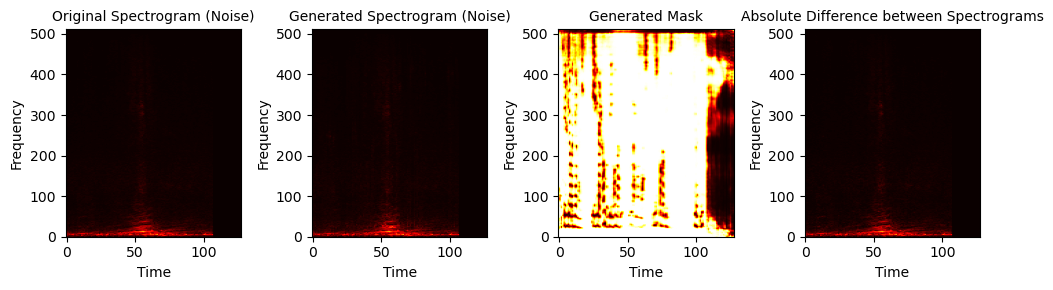

In [27]:
X, Y = noise_test_dataset[idx]
X_ = X.unsqueeze(0).unsqueeze(0).to(device)
output = noise_model(X_)

pred = output * X_

Vtrue = Y.detach().cpu().numpy()  # Move to CPU before converting to NumPy
Vpred = (pred).squeeze().detach().cpu().numpy()  # Move to CPU before converting to NumPy
mask = output.squeeze().detach().cpu().numpy()

print(Vpred.shape, Vtrue.shape)

fig, axs = plt.subplots(1, 4, figsize=(10, 3))

axs[0].imshow(Vtrue, aspect='auto', origin='lower', cmap='hot')
axs[0].set_title('Original Spectrogram (Noise)', fontsize=10)  # Reduce title size
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Frequency')

axs[1].imshow(Vpred, aspect='auto', origin='lower', cmap='hot')
axs[1].set_title('Generated Spectrogram (Noise)', fontsize=10)  # Reduce title size
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Frequency')

axs[2].imshow(mask, aspect='auto', origin='lower', cmap='hot')
axs[2].set_title('Generated Mask', fontsize=10)  # Reduce title size
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Frequency')

axs[3].imshow(np.abs(Vpred - Vtrue), aspect='auto', origin='lower', cmap='hot')
axs[3].set_title('Absolute Difference between Spectrograms', fontsize=10)  # Reduce title size
axs[3].set_xlabel('Time')
axs[3].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('Figs/UNet_noise_sp.png')

plt.show()

*Comparaison qualitative son original/son généré :*

In [28]:
reconstructed_true = noise_test_dataset.reconstruct(Y, id0=idx, reference = 'noise')
IPython.display.Audio(reconstructed_true.detach().numpy(), rate=8000)

In [29]:
reconstructed_output = noise_test_dataset.reconstruct(pred.cpu(), id0=idx, reference='noise')
IPython.display.Audio(reconstructed_output.detach().numpy(), rate=8000)

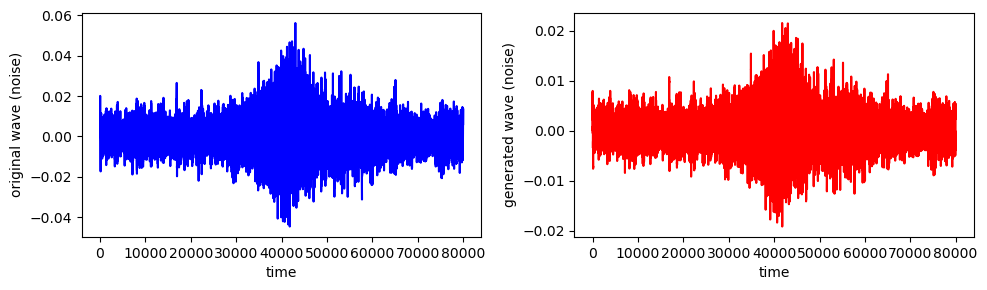

In [30]:
S_true = reconstructed_true.squeeze().detach().numpy()
S_pred = reconstructed_output.squeeze().detach().numpy()
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].plot(S_true, color='blue')
axs[0].set_xlabel('time')
axs[0].set_ylabel('original wave (noise)')

axs[1].plot(S_pred, color='red')
axs[1].set_xlabel('time')
axs[1].set_ylabel('generated wave (noise)')
plt.savefig('Figs/UNet_noise_wave.png')

plt.tight_layout()

#### -- Comparaison des résultats par SNR de base --- 

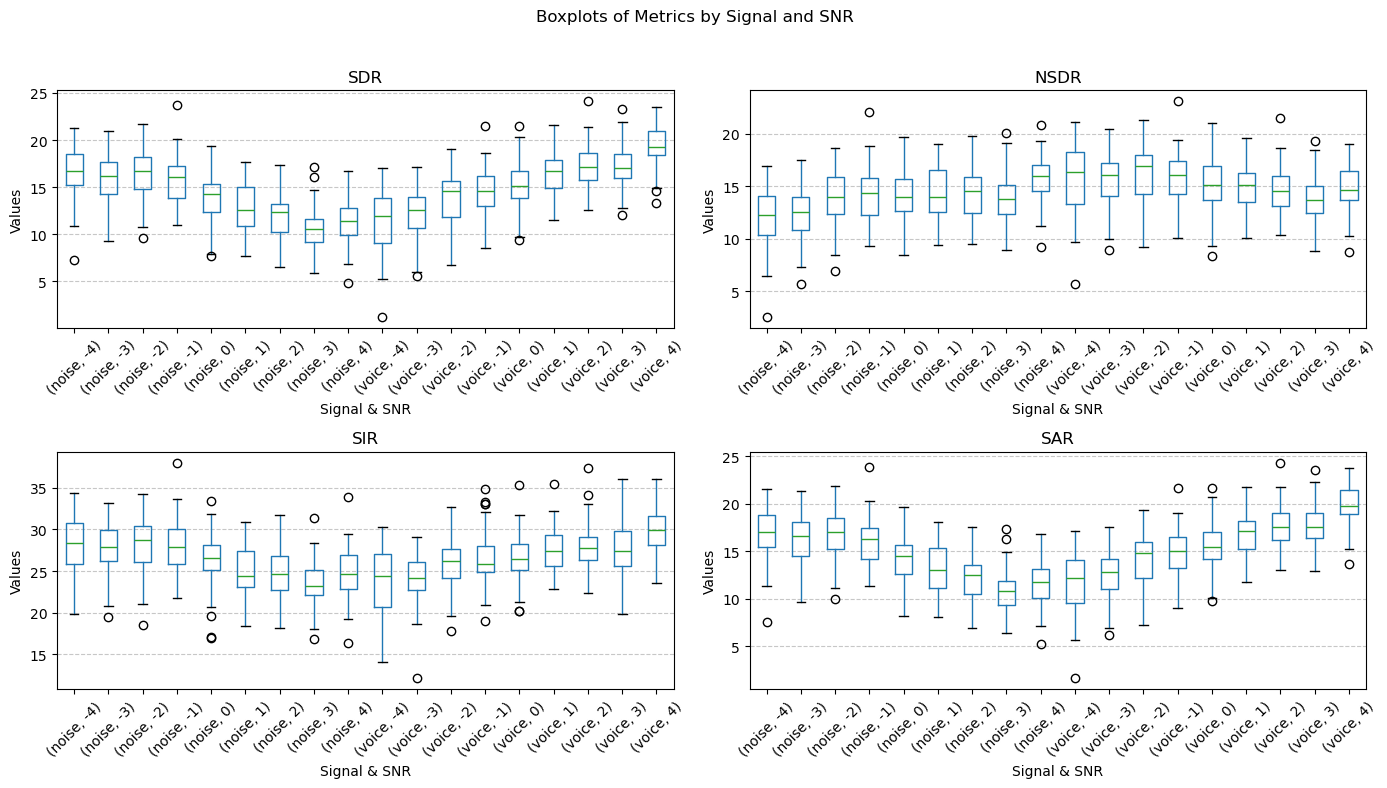

In [31]:
metrics_dir = "Scores/UNet/"

metrics_by_snr = {}

# Liste des SNR et des signaux que vous avez enregistrés
snr_values = np.arange(-4,5)  
signals = ['voice', 'noise']  

# Lire les fichiers CSV pour chaque combinaison SNR et Signal
for snr in snr_values:
    metrics_by_snr[snr] = {}  
    for signal in signals:
        # Construire le chemin du fichier correspondant pour ce signal et SNR
        file_path = os.path.join(metrics_dir, f'val_metrics_SNR_{snr}_{signal}.csv')
        if os.path.exists(file_path):
            #print(file_path)
            # Lire le fichier CSV dans un DataFrame
            df = pd.read_csv(file_path)
            
            # Stocker les métriques pour ce signal et SNR
            metrics_by_snr[snr][signal] = df

# Combiner les données pour chaque signal et SNR
all_data = []
for snr, metrics in metrics_by_snr.items():
    for signal, df in metrics.items():
        df['SNR'] = snr
        df['Signal'] = signal
        all_data.append(df)

# Créer un DataFrame combiné
combined_df = pd.concat(all_data, ignore_index=True)

# Tracer les boxplots pour chaque métrique
metrics = ['SDR', 'NSDR', 'SIR', 'SAR']
plt.figure(figsize=(14, 8))

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    combined_df.boxplot(column=metric, by=['Signal', 'SNR'], grid=False, ax=plt.gca())
    plt.title(metric)
    plt.xlabel('Signal & SNR')
    plt.ylabel('Values')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajouter un titre principal et ajuster la mise en page
plt.suptitle('Boxplots of Metrics by Signal and SNR')
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Sauvegarder le graphique
output_path = 'Figs/UNet_val_metrics.png'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
plt.savefig(output_path)

# Afficher le graphique
plt.show()

___
### 3. UNet à deux canaux de sortie

Au lieu d'entrainer deux modèles qui apprennent à générer les deux sources distinctes, l'architecture ci-dessous génère les deux masques simultanément sur deux canaux distincts en sortie du réseau en s'inspirant du modèle WaveUNet. Cela permet d'entrainer le modèle sur la même base de paramètres : on analyse l'efficicacité de ce modèle sur nos données.

*Description des dimensions sur les couches du réseau de neurones :*

In [11]:
model = UNet2().to(device)
summary(model, input_size = (1,512,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 256, 64]             416
       BatchNorm2d-2          [-1, 16, 256, 64]              32
         LeakyReLU-3          [-1, 16, 256, 64]               0
       EncodeBlock-4          [-1, 16, 256, 64]               0
            Conv2d-5          [-1, 32, 128, 32]          12,832
       BatchNorm2d-6          [-1, 32, 128, 32]              64
         LeakyReLU-7          [-1, 32, 128, 32]               0
       EncodeBlock-8          [-1, 32, 128, 32]               0
            Conv2d-9           [-1, 64, 64, 16]          51,264
      BatchNorm2d-10           [-1, 64, 64, 16]             128
        LeakyReLU-11           [-1, 64, 64, 16]               0
      EncodeBlock-12           [-1, 64, 64, 16]               0
           Conv2d-13           [-1, 128, 32, 8]         204,928
      BatchNorm2d-14           [-1, 128

*Nombre de paramètres : ~39.3M (couches supplémentaires ajoutées par rapport au UNet)*

In [12]:
np.sum([p.numel() for p in model.parameters()])

39319932

*Chargement des données pour l'entrainement du UNet2 :*

In [13]:
train_dataset = Audiodataset('train',  padding=True, getitem='all')
train_dataset.take_spectrogram()

test_dataset = Audiodataset('test', padding=True, getitem='all')
test_dataset.take_spectrogram()

*Entrainement :*

In [19]:
# ==== Entrainement +20 epochs ====
# model, losses = UNet2.trainModel(train_dataset, n_epochs=30, batch_size=16, learning_rate=0.0001, valid_dataset=test_dataset)

*Evolution de la fonction de perte :*

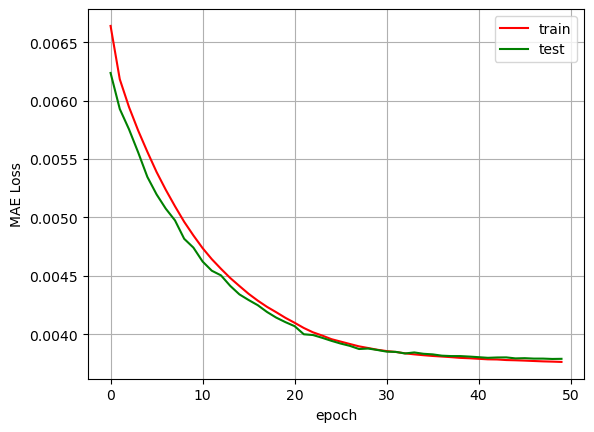

In [16]:
scores_WaveUNet = pd.read_csv('Scores/UNet2/UNet2MAE.csv')
train_error = scores_WaveUNet['train']
valid_error = scores_WaveUNet['valid']
plt.plot(train_error, color='red', label='train')
plt.plot(valid_error, color='green', label='test')

plt.grid()
plt.legend()
plt.xlabel('epoch')
plt.ylabel('MAE Loss')
plt.savefig('Figs/UNet2_loss.png')

*Visualisation d'un masque estimé et écoute de la qualité audio :*

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UNet2().to(device)
model.load_state_dict(torch.load('Paths/UNet2/model_50.pth', map_location=device))

idx = 2

C:\Users\User\AppData\Local\Temp\ipykernel_20444\3110868758.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('Paths/UNet2/model_50.pth', 

c:\Users\User\anaconda3\Lib\site-packages\torch\functional.py:704: UserWarning: A window was not provided. A rectangular window will be applied,which is known to cause spectral leakage. Other windows such as torch.hann_window or torch.hamming_window can are recommended to reduce spectral leakage.To suppress this warning and use a rectangular window, explicitly set `window=torch.ones(n_fft, device=<device>)`. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\SpectralOps.cpp:842.)
  return _VF.stft(  # type: ignore[attr-defined]


(2, 512, 128) (2, 512, 128)


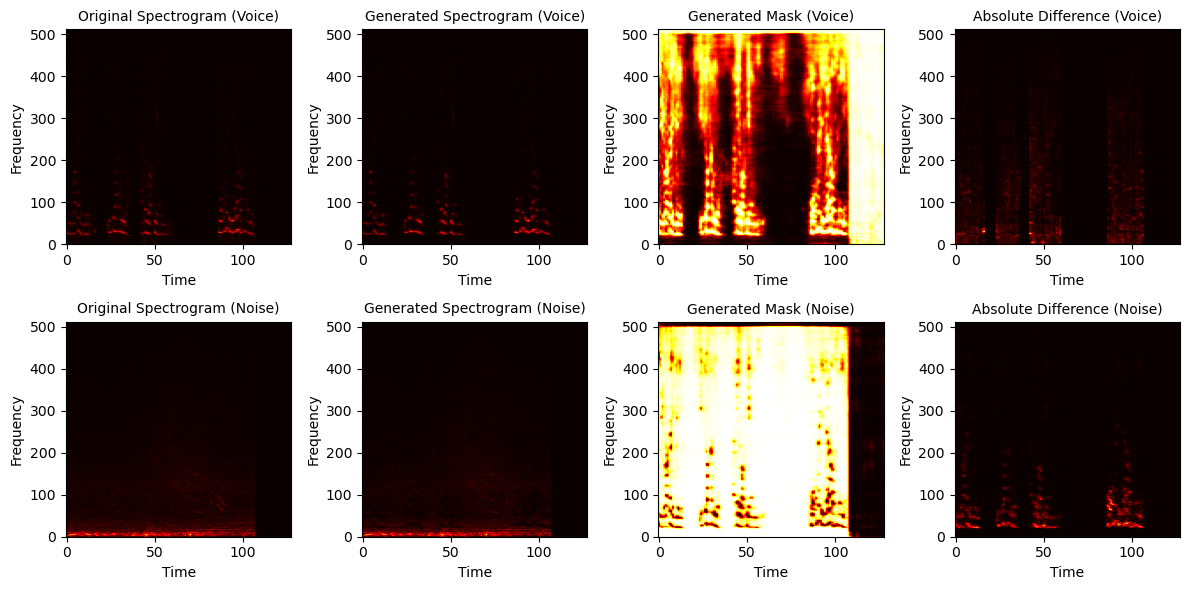

In [18]:
X, voice,noise, _, _ = test_dataset[idx]
output = model(X.unsqueeze(0).unsqueeze(0).to(device)).squeeze()
voice_ = voice.unsqueeze(0)
noise_ = noise.unsqueeze(0)
Y = torch.cat((voice_, noise_), dim=0).to(device)  # Concatenate along the channel dimension

pred = output * Y

Vpred = (pred).squeeze().detach().cpu().numpy()  
mask = output.squeeze().detach().cpu().numpy()
voice_ = voice_.squeeze().detach().cpu().numpy()
noise_ = noise_.squeeze().detach().cpu().numpy()
print(Vpred.shape, mask.shape)

fig, axs = plt.subplots(2, 4, figsize=(12, 6)) 

axs[0, 0].imshow(voice_, aspect='auto', origin='lower', cmap='hot')
axs[0, 0].set_title('Original Spectrogram (Voice)', fontsize=10)
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Frequency')

axs[0, 1].imshow(Vpred[0], aspect='auto', origin='lower', cmap='hot')
axs[0, 1].set_title('Generated Spectrogram (Voice)', fontsize=10)
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Frequency')

axs[0, 2].imshow(mask[0], aspect='auto', origin='lower', cmap='hot')
axs[0, 2].set_title('Generated Mask (Voice)', fontsize=10)
axs[0, 2].set_xlabel('Time')
axs[0, 2].set_ylabel('Frequency')

axs[0, 3].imshow(np.abs(Vpred[0] - voice_), aspect='auto', origin='lower', cmap='hot')
axs[0, 3].set_title('Absolute Difference (Voice)', fontsize=10)
axs[0, 3].set_xlabel('Time')
axs[0, 3].set_ylabel('Frequency')

axs[1, 0].imshow(noise_, aspect='auto', origin='lower', cmap='hot')
axs[1, 0].set_title('Original Spectrogram (Noise)', fontsize=10)
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Frequency')

axs[1, 1].imshow(Vpred[1], aspect='auto', origin='lower', cmap='hot')
axs[1, 1].set_title('Generated Spectrogram (Noise)', fontsize=10)
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Frequency')

axs[1, 2].imshow(mask[1], aspect='auto', origin='lower', cmap='hot')
axs[1, 2].set_title('Generated Mask (Noise)', fontsize=10)
axs[1, 2].set_xlabel('Time')
axs[1, 2].set_ylabel('Frequency')

axs[1, 3].imshow(np.abs(Vpred[1] - noise_), aspect='auto', origin='lower', cmap='hot')
axs[1, 3].set_title('Absolute Difference (Noise)', fontsize=10)
axs[1, 3].set_xlabel('Time')
axs[1, 3].set_ylabel('Frequency')

plt.tight_layout()  
plt.savefig('Figs/UNet2_sp.png')  
plt.show()  

___
### 4. WaveUNet

On se concentre dans cette partie sur l'implémentation d'un modèle génératif basé directement sur la forme d'onde sans passer sur la représentation temps/fréquence de la magnitude du signal.
On implémente le modèle dans des conditions similaires à celles décrites par *Stoller et al. (2018) https://arxiv.org/pdf/1806.03185*

L'architecture est un UNet sur la forme d'onde (structure encodeur/decodeur), composé de 12 layers d'encoding vers un espace de dimension réduit et 12 layers de upsampling pour retrouver le signal original masqué sur les composantes de bruit et de voix. Chaque étape de upsampling est contextualisé par une copie de l'état de downsampling à la même étape. Contrairement à un UNet classique, les auteurs proposent deux différences sur les méthodes de downsampling et de upsampling : 
- Les encodeurs réduisent la taille du signal d'entrée par décimation en supprimant de moitié les valeurs retenues de l'étape précédente
- les décodeurs réalisent un upsampling par interpolation linéaire au lieu de convolutions transposées, afin d'obtenir un meilleur lissage du signal et limiter l'apparition d'artefacts

Dans notre cas on décide de rééchantilloner le signal avec 65536 points au total sur les dix secondes d'audio (downsample avec taille en puissance de 2 pour simplifier le calcul des dimensions de convolution)

In [20]:
from Models.WaveUNet import *

N_POINTS = 65536

*Taille du modèle estimé (en nombre de paramètres) : ~ 10.26M*

In [21]:
model = WaveUNet().to(device)
print(np.sum([p.numel() for p in model.parameters()]))

10263028


*Détail des dimensions sur les couches du réseau de neurones :*

In [22]:
summary(model, input_size=(1, 65536))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1            [-1, 24, 65536]             384
         LeakyReLU-2            [-1, 24, 65536]               0
       Downsampler-3            [-1, 24, 65536]               0
            Conv1d-4            [-1, 48, 32768]          17,328
         LeakyReLU-5            [-1, 48, 32768]               0
       Downsampler-6            [-1, 48, 32768]               0
            Conv1d-7            [-1, 72, 16384]          51,912
         LeakyReLU-8            [-1, 72, 16384]               0
       Downsampler-9            [-1, 72, 16384]               0
           Conv1d-10             [-1, 96, 8192]         103,776
        LeakyReLU-11             [-1, 96, 8192]               0
      Downsampler-12             [-1, 96, 8192]               0
           Conv1d-13            [-1, 120, 4096]         172,920
        LeakyReLU-14            [-1, 12

*Chargement des données pour WaveUNet :*

In [23]:
train_dataset = Audiodataset('train', resample_n_points=N_POINTS, getitem='concatVN')
train_dataset.take_wave()

test_dataset = Audiodataset('test', resample_n_points=N_POINTS, getitem='concatVN')
test_dataset.take_wave()

On utilise un batch size de 16 seulement (haute demande en ressources mémoires durant les étapes de downsampling) et un learning rate initial de 0.0001 pour l'optimiseur Adam comme décris dans l'article pour le modèle baseline :

In [25]:
# ==== Entrainement +20 epochs ====
# model, losses = WaveUNet.trainModel(train_dataset, n_epochs=20, batch_size=16, learning_rate=0.001, valid_dataset=test_dataset)

#### 4.3 Evolution de la loss (MSE error) : 

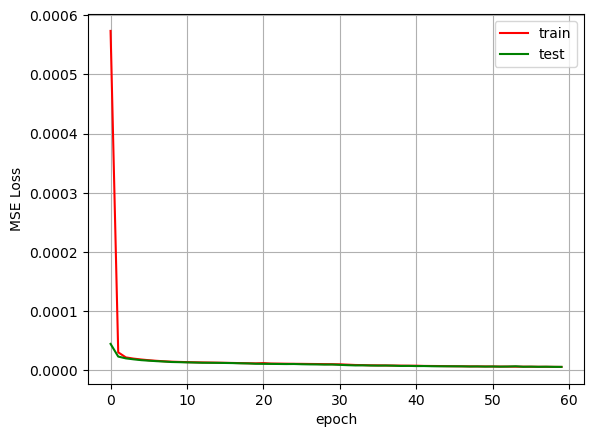

In [26]:
scores_WaveUNet = pd.read_csv('Scores/WaveUNet/WaveUNetMSE.csv')
train_error = scores_WaveUNet['train']
valid_error = scores_WaveUNet['valid']

plt.plot(train_error, color='red', label='train')
plt.plot(valid_error, color='green', label='test')
plt.grid()
plt.legend()
plt.xlabel('epoch')
plt.ylabel('MSE Loss')
plt.savefig('Figs/WaveUNetLoss.png')

#### 4.4 Ecoute sur une donnée de test

Visualisation et écoute de la performance du modèle génératif :

In [27]:
idx = 0

In [28]:
X, Y = test_dataset[idx]
model = WaveUNet()
model.load_state_dict(torch.load('Paths/WaveUNet/model_40.pth'))
output = model(X.unsqueeze(0))

C:\Users\User\AppData\Local\Temp\ipykernel_20444\333822859.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('Paths/WaveUNet/model_40.pth'

*Comparaison Voix originale/Voix générée :*

C:\Users\User\AppData\Local\Temp\ipykernel_20444\4088492110.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend()
C:\Users\User\AppData\Local\Temp\ipykernel_20444\4088492110.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()


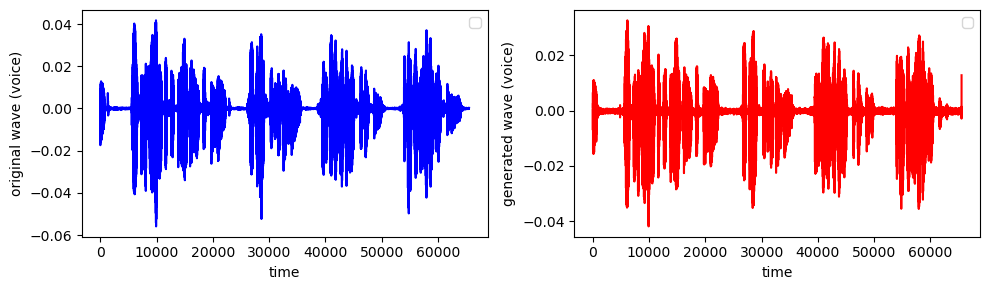

In [29]:
Vtrue = Y[0,:].squeeze().detach().numpy()
Vpred = output[:,0,:].squeeze().detach().numpy()

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].plot(Vtrue, color='blue')
axs[0].legend()
axs[0].set_xlabel('time')
axs[0].set_ylabel('original wave (voice)')

axs[1].plot(Vpred, color='red')
axs[1].legend()
axs[1].set_xlabel('time')
axs[1].set_ylabel('generated wave (voice)')

plt.tight_layout()
plt.savefig('Figs/WaveUNetVoiceEx.png')

*Comparaison Bruit original/Bruit généré :*

C:\Users\User\AppData\Local\Temp\ipykernel_20444\2963105354.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend()
C:\Users\User\AppData\Local\Temp\ipykernel_20444\2963105354.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()


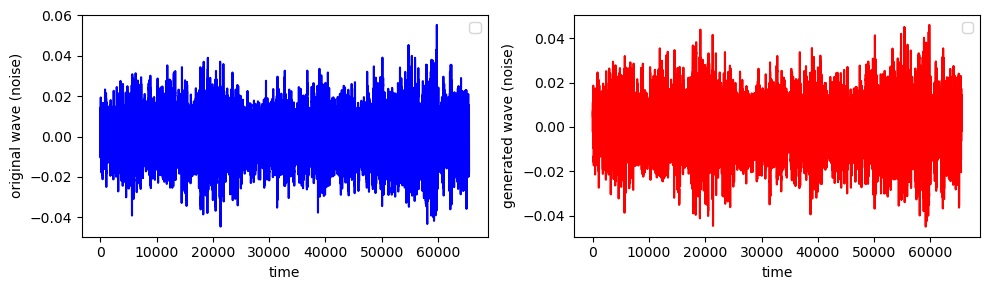

In [30]:
Ntrue = Y[1,:].squeeze().detach().numpy()
Npred = output[:,1,:].squeeze().detach().numpy()

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].plot(Ntrue, color='blue')
axs[0].legend()
axs[0].set_xlabel('time')
axs[0].set_ylabel('original wave (noise)')

axs[1].plot(Npred, color='red')
axs[1].legend()
axs[1].set_xlabel('time')
axs[1].set_ylabel('generated wave (noise)')

plt.tight_layout()
plt.savefig('Figs/WaveUNetNoiseEx.png')

*Ecoute du son original (bruité)/voix originale/voix générée/bruit original/bruit généré :*

In [33]:
# son original
IPython.display.Audio(X.squeeze().detach().numpy(), rate=N_POINTS/10)

In [34]:
# voix originale
IPython.display.Audio(Vtrue, rate=N_POINTS/10)

In [35]:
# voix générée (extraite du son original)
IPython.display.Audio(Vpred, rate=N_POINTS/10)

In [36]:
# bruit original
IPython.display.Audio(Ntrue, rate=N_POINTS/10)

In [37]:
# bruit généré (extrait du son original)
IPython.display.Audio(Npred, rate=N_POINTS/10)

### 4.5 Comparaison selon le SNR des données test 

*SNR estimé à partir du bruit résiduel :*

In [55]:
model.eval()
model.to(device)

SNRV = []
SNRN = []

criterion = torch.nn.MSELoss()

for snr in tqdm(range(-4, 5)):

    test_dataset = Audiodataset('test', resample_n_points=N_POINTS, snr_filter=snr, getitem='concatVN')
    test_dataset.take_wave()    
    test_dataloader = DataLoader(test_dataset, batch_size=16)

    numsV = 0.0
    denomsV = 0.0
    numsN = 0.0
    denomsN = 0.0

    for X, Y in test_dataloader:

        X, Y = X.to(device), Y.to(device)
        output = model(X)
        
        Vpred = output[:,0,:]
        Npred = output[:,1,:]
        
        numsV += torch.sum((Y[:,0,:]**2).squeeze()).item()
        denomsV += torch.sum( ((Y[:,0,:] - Vpred)**2).squeeze() ).item()

        numsN += torch.sum((Y[:,1,:]**2).squeeze()).item()
        denomsN += torch.sum( ((Y[:,1,:] - Npred)**2).squeeze() ).item()

    SNRV.append(10*np.log10(numsV/denomsV))
    SNRN.append(10*np.log10(numsN/denomsN))

100%|██████████| 9/9 [00:26<00:00,  2.99s/it]


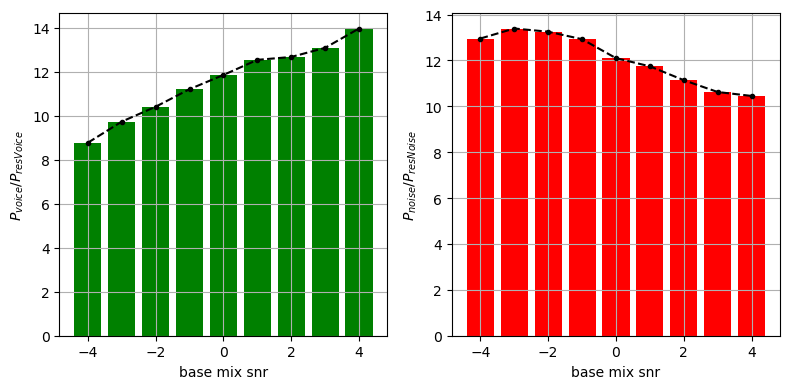

In [56]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

ax = axs[0]
ax.bar(range(-4, 5), SNRV, color='green')
ax.plot(range(-4, 5), SNRV, color='black', marker='.', linestyle='--')
ax.grid()
ax.set_ylabel('$P_{voice}/P_{resVoice}$')
ax.set_xlabel('base mix snr')

ax = axs[1]
ax.bar(range(-4, 5), SNRN, color='red')
ax.plot(range(-4, 5), SNRN, color='black', marker='.', linestyle='--')
ax.grid()
ax.set_ylabel('$P_{noise}/P_{resNoise}$')
ax.set_xlabel('base mix snr')

plt.tight_layout()
plt.savefig('Figs/WaveUNetSNR.png')

___
### 5. Conv-TasNet

Le dernier modèle implémenté est un encodeur/décodeur réalisant des convolutions succesives avec dilatation dans l'espace des features pour augmenter la capture de relations temporelles. Contrairement au WaveUNet, le modèle apprend à générer un masque qui est appliqué dans l'espace latent avant l'étape de decoding. Les entrées et sorties sont, comme pour le WaveUnet, fournies sous la forme d'onde ce qui permet d'éviter la reconstruction du signal depuis la représentation temps/fréquence.

Pour ce modèle nous reprenons une sélection d'hyperparamètres affichant les meilleurs résultats empiriques obtenus par *Yi Luo et al.* https://arxiv.org/pdf/1809.07454 (2019)

*Modèle et descritpion des dimensions des couches du réseau :*

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ConvTasNet(2).to(device)

In [6]:
summary(model, input_size=(1, 80000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1            [-1, 256, 5002]           8,192
         GroupNorm-2            [-1, 256, 5002]             512
            Conv1d-3             [-1, 64, 5002]          16,448
            Conv1d-4            [-1, 256, 5002]          16,640
             PReLU-5            [-1, 256, 5002]               1
         GroupNorm-6            [-1, 256, 5002]             512
            Conv1d-7            [-1, 256, 5002]         196,864
             PReLU-8            [-1, 256, 5002]               1
         GroupNorm-9            [-1, 256, 5002]             512
           Conv1d-10             [-1, 64, 5002]          16,448
           Conv1d-11             [-1, 64, 5002]          16,448
              C1D-12  [[-1, 64, 5002], [-1, 64, 5002]]               0
           Conv1d-13            [-1, 256, 5002]          16,640
            PReLU-14            

c:\Users\User\anaconda3\Lib\site-packages\torchsummary\torchsummary.py:93: RuntimeWarning: overflow encountered in scalar add
  total_output += np.prod(summary[layer]["output_shape"])


*Nombre de paramètres du modèles :~3.04M*

In [7]:
np.sum([p.numel() for p in model.parameters()])

3035737

*Données d'entrainement :*

In [8]:
train_dataset = Audiodataset('train', getitem='concatVN')
train_dataset.take_wave()

test_dataset = Audiodataset('test', getitem='concatVN')
test_dataset.take_wave()

*Entrainement :*

In [42]:
# ==== Entrainement ====
model, losses = ConvTasNet.trainModel(train_dataset, 10, batch_size=16, valid_dataset=test_dataset)

c:\Users\User\Documents\Projets\dlts-project\Models\TasNet.py:194: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(PATH, f'model_

Epoch 11/20 - Train Loss : -11.926828
Valid Loss : -12.295543


100%|██████████| 313/313 [02:07<00:00,  2.46it/s]


Epoch 12/20 - Train Loss : -12.201924
Valid Loss : -12.474865


100%|██████████| 313/313 [01:59<00:00,  2.62it/s]


Epoch 13/20 - Train Loss : -12.329200
Valid Loss : -12.460210


100%|██████████| 313/313 [01:53<00:00,  2.76it/s]


Epoch 14/20 - Train Loss : -12.481508
Valid Loss : -12.269508


100%|██████████| 313/313 [01:53<00:00,  2.77it/s]


Epoch 15/20 - Train Loss : -12.595905
Valid Loss : -12.205489


100%|██████████| 313/313 [01:53<00:00,  2.76it/s]


Epoch 16/20 - Train Loss : -12.758746
Valid Loss : -12.723913


100%|██████████| 313/313 [01:53<00:00,  2.76it/s]


Epoch 17/20 - Train Loss : -12.792887
Valid Loss : -12.749810


100%|██████████| 313/313 [01:53<00:00,  2.76it/s]


Epoch 18/20 - Train Loss : -12.961965
Valid Loss : -12.753527


100%|██████████| 313/313 [01:53<00:00,  2.77it/s]


Epoch 19/20 - Train Loss : -13.037124
Valid Loss : -12.931623


100%|██████████| 313/313 [01:52<00:00,  2.77it/s]


Epoch 20/20 - Train Loss : -13.187012
Valid Loss : -12.710337


c:\Users\User\Documents\Projets\dlts-project\Models\TasNet.py:263: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scores = pd.concat([scores, pd.DataFrame({


*Fonction de perte :*

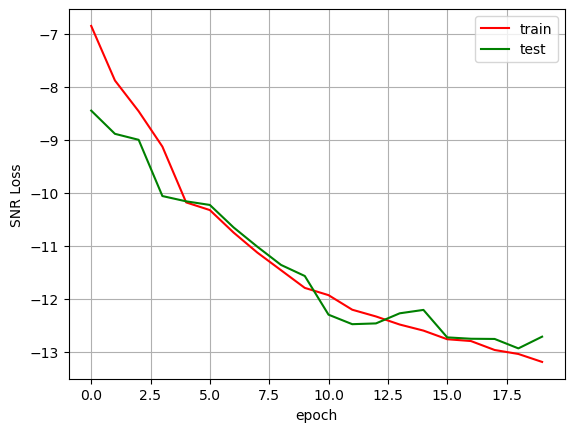

In [36]:
scores_WaveUNet = pd.read_csv('Scores/TasNet/TasNetSNRLoss.csv')
train_error = scores_WaveUNet['train']
valid_error = scores_WaveUNet['valid']

plt.plot(train_error, color='red', label='train')
plt.plot(valid_error, color='green', label='test')
plt.grid()
plt.legend()
plt.xlabel('epoch')

plt.ylabel('SNR Loss')
plt.savefig('Figs/TasNetSNRLoss.png')

*Comparaison des signaux sur une donnée test :*

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ConvTasNet(2).to(device)
model.load_state_dict(torch.load("Paths/TasNet/model_20.pth"))

C:\Users\User\AppData\Local\Temp\ipykernel_22708\2232541393.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("Paths/TasNet/model_20.pth")

<All keys matched successfully>

In [28]:
idx = 1
X, Y = test_dataset[idx]
output = model(X.to(device).unsqueeze(0))

C:\Users\User\AppData\Local\Temp\ipykernel_22708\1259209301.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend()
C:\Users\User\AppData\Local\Temp\ipykernel_22708\1259209301.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()


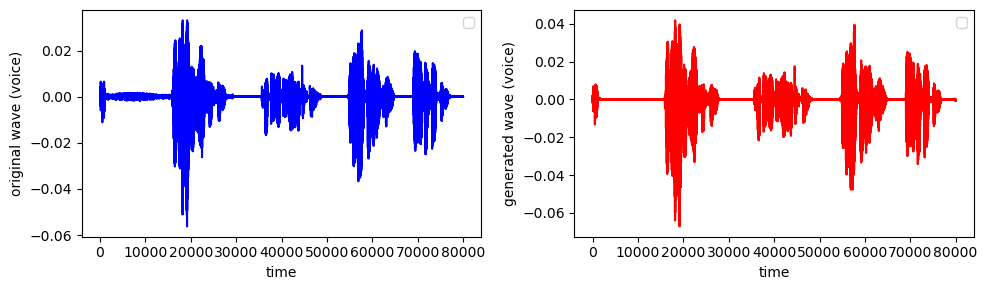

In [29]:
Vtrue = Y[0,:].squeeze().cpu().detach().numpy()
Vpred = output[:,0,:].squeeze().cpu().detach().numpy()

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].plot(Vtrue, color='blue')
axs[0].legend()
axs[0].set_xlabel('time')
axs[0].set_ylabel('original wave (voice)')

axs[1].plot(Vpred, color='red')
axs[1].legend()
axs[1].set_xlabel('time')
axs[1].set_ylabel('generated wave (voice)')

plt.tight_layout()
plt.savefig('Figs/TasNet.png')

C:\Users\User\AppData\Local\Temp\ipykernel_22708\1796158884.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend()
C:\Users\User\AppData\Local\Temp\ipykernel_22708\1796158884.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()


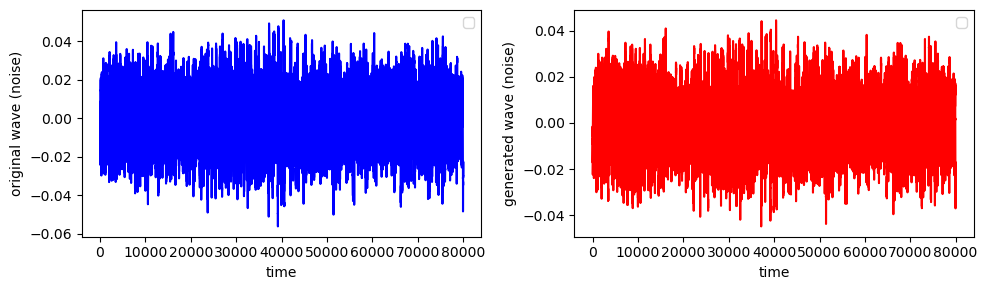

In [30]:
Ntrue = Y[1,:].squeeze().cpu().detach().numpy()
Npred = output[:,1,:].squeeze().cpu().detach().numpy()

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].plot(Ntrue, color='blue')
axs[0].legend()
axs[0].set_xlabel('time')
axs[0].set_ylabel('original wave (noise)')

axs[1].plot(Npred, color='red')
axs[1].legend()
axs[1].set_xlabel('time')
axs[1].set_ylabel('generated wave (noise)')

plt.tight_layout()
plt.savefig('Figs/WaveUNetNoiseEx.png')

*Ecoute qualitative :*

In [31]:
# son original
IPython.display.Audio(X.squeeze().detach().numpy(), rate=8000)

In [32]:
# voix originale
IPython.display.Audio(Vtrue, rate=8000)

In [33]:
# voix générée (extraite du son original)
IPython.display.Audio(Vpred, rate=8000)

In [34]:
# bruit original
IPython.display.Audio(Ntrue, rate=8000)

In [35]:
# bruit généré (extrait du son original)
IPython.display.Audio(Npred, rate=8000)

*Evaluation du SNR :*

In [12]:
model.eval()
model.to(device)

SNRV = []
SNRN = []

for snr in tqdm(range(-4, 5)):

    test_dataset = Audiodataset('test', snr_filter=snr, getitem='concatVN')
    test_dataset.take_wave()    
    test_dataloader = DataLoader(test_dataset, batch_size=16)

    numsV = 0.0
    denomsV = 0.0
    numsN = 0.0
    denomsN = 0.0

    for X, Y in test_dataloader:

        X, Y = X.to(device), Y.to(device)
        output = model(X)
        
        Vpred = output[:,0,:]
        Npred = output[:,1,:]
        
        numsV += torch.sum((Y[:,0,:]**2).squeeze()).item()
        denomsV += torch.sum( ((Y[:,0,:] - Vpred)**2).squeeze() ).item()

        numsN += torch.sum((Y[:,1,:]**2).squeeze()).item()
        denomsN += torch.sum( ((Y[:,1,:] - Npred)**2).squeeze() ).item()

    SNRV.append(10*np.log10(numsV/denomsV))
    SNRN.append(10*np.log10(numsN/denomsN))

100%|██████████| 9/9 [00:53<00:00,  5.93s/it]


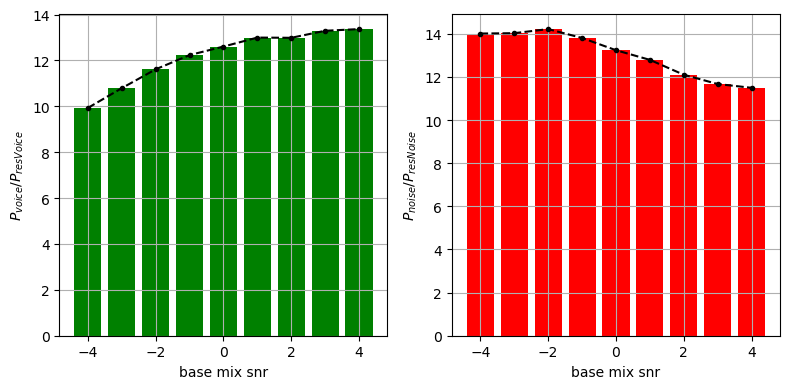

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

ax = axs[0]
ax.bar(range(-4, 5), SNRV, color='green')
ax.plot(range(-4, 5), SNRV, color='black', marker='.', linestyle='--')
ax.grid()
ax.set_ylabel('$P_{voice}/P_{resVoice}$')
ax.set_xlabel('base mix snr')

ax = axs[1]
ax.bar(range(-4, 5), SNRN, color='red')
ax.plot(range(-4, 5), SNRN, color='black', marker='.', linestyle='--')
ax.grid()
ax.set_ylabel('$P_{noise}/P_{resNoise}$')
ax.set_xlabel('base mix snr')

plt.tight_layout()
plt.savefig('Figs/TasNetSNR.png')